In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rescorla_wagner(V, alpha, beta, lambda_, stimuli):
    V_history = []
    for trial in range(len(stimuli)):
        V_tot = np.sum([V[stim] for stim in stimuli[trial]])
        for stim in stimuli[trial]:
            delta_V = alpha * beta * (lambda_ - V_tot)
            V[stim] += delta_V
        V_history.append(V.copy())
    return V_history


In [ ]:
def rescorla_wagner_latent(V, alpha, beta, gamma, lambda_, stimuli):
    V_history = []
    for trial in range(len(stimuli)):
        V_tot = np.sum([V[stim] for stim in stimuli[trial]])
        for stim in stimuli[trial]:
            delta_V = alpha * beta * (lambda_ - V_tot) + gamma
            V[stim] += delta_V
        V_history.append(V.copy())
    return V_history


In [ ]:
def rescorla_wagner_nonlinear(V, alpha, beta, lambda_, stimuli, f):
    V_history = []
    for trial in range(len(stimuli)):
        V_tot = f(np.sum([V[stim] for stim in stimuli[trial]]))
        for stim in stimuli[trial]:
            delta_V = alpha * beta * (lambda_ - V_tot)
            V[stim] += delta_V
        V_history.append(V.copy())
    return V_history


In [ ]:
def rescorla_wagner_extinction(V_active, V_inactive, alpha, beta, eta, lambda_, stimuli, phase):
    V_history = []
    for trial in range(len(stimuli)):
        V_tot = np.sum([V_active[stim] for stim in stimuli[trial]])
        for stim in stimuli[trial]:
            if phase[trial] == 'acquisition':
                delta_V = alpha * beta * (lambda_ - V_tot)
            elif phase[trial] == 'extinction':
                delta_V = -alpha * beta * V_tot
                V_inactive[stim] += eta * V_active[stim]
            V_active[stim] += delta_V
        V_history.append((V_active.copy(), V_inactive.copy()))
    return V_history


In [ ]:
def rescorla_wagner_weighted(V, alpha, beta, lambda_, stimuli, W):
    V_history = []
    for trial in range(len(stimuli)):
        V_tot = np.sum([W[i][j] * V[j] for i in stimuli[trial] for j in stimuli[trial]])
        for stim in stimuli[trial]:
            delta_V = alpha * beta * (lambda_ - V_tot)
            V[stim] += delta_V
        V_history.append(V.copy())
    return V_history


In [ ]:
def rescorla_wagner_enhanced(V_active, V_inactive, alpha, beta, gamma, eta, lambda_, stimuli, W, f, phase):
    V_history = []
    for trial in range(len(stimuli)):
        V_tot = f(np.sum([W[i][j] * V_active[j] for i in stimuli[trial] for j in stimuli[trial]]))
        for stim in stimuli[trial]:
            if phase[trial] == 'acquisition':
                delta_V = alpha * beta * (lambda_ - V_tot) + gamma - eta * V_active[stim]
            elif phase[trial] == 'extinction':
                delta_V = -alpha * beta * V_tot + gamma - eta * V_active[stim]
                V_inactive[stim] += eta * V_active[stim]
            V_active[stim] += delta_V
        V_history.append((V_active.copy(), V_inactive.copy()))
    return V_history


In [ ]:
alpha = 0.1
beta = 0.1
gamma = 0.01
lambda_ = 1.0
trials = 100

V_original = {'A': 0.0}
V_latent = {'A': 0.0}

stimuli = [['A'] for _ in range(trials)]

V_history_original = rescorla_wagner(V_original.copy(), alpha, beta, lambda_=0, stimuli=stimuli)
V_history_latent = rescorla_wagner_latent(V_latent.copy(), alpha, beta, gamma, lambda_=0, stimuli=stimuli)

V_values_original = [V['A'] for V in V_history_original]
V_values_latent = [V['A'] for V in V_history_latent]


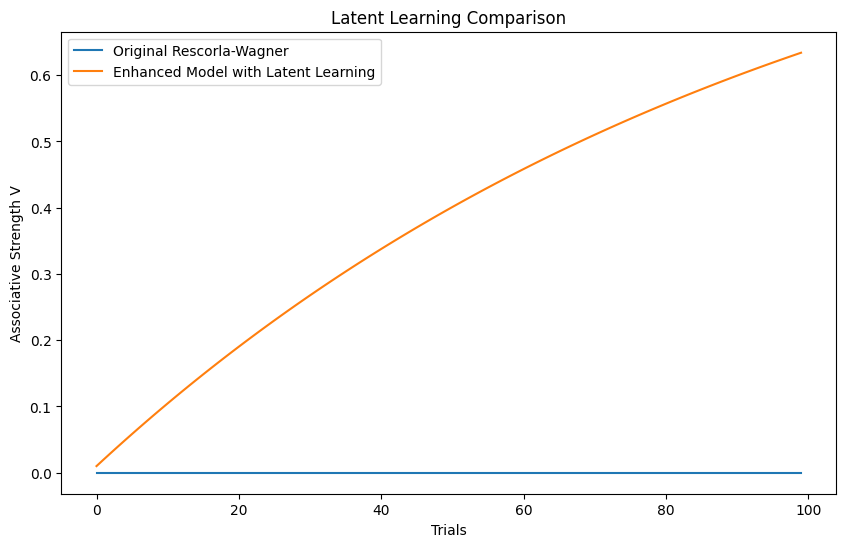

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(V_values_original, label='Original Rescorla-Wagner')
plt.plot(V_values_latent, label='Enhanced Model with Latent Learning')
plt.xlabel('Trials')
plt.ylabel('Associative Strength V')
plt.title('Latent Learning Comparison')
plt.legend()
plt.show()


The graph shows that in the original model, no learning occurs since there's no reinforcement. In the enhanced model, associative strength gradually increases due to the baseline learning rate γ.

# Blocking and Configural Learning

In [ ]:
alpha = 0.1
beta = 0.1
lambda_ = 1.0
trials = 50

V_original = {'A': 0.0, 'B': 0.0}
V_nonlinear = {'A': 0.0, 'B': 0.0}

stimuli_phase1 = [['A'] for _ in range(trials)]
stimuli_phase2 = [['A', 'B'] for _ in range(trials)]

def f(V_tot):
    return V_tot**2  # One Example of a non-linear function

V_history_original = rescorla_wagner(V_original.copy(), alpha, beta, lambda_, stimuli_phase1)
V_history_nonlinear = rescorla_wagner_nonlinear(V_nonlinear.copy(), alpha, beta, lambda_, stimuli_phase1, f)

V_history_original += rescorla_wagner(V_history_original[-1].copy(), alpha, beta, lambda_, stimuli_phase2)
V_history_nonlinear += rescorla_wagner_nonlinear(V_history_nonlinear[-1].copy(), alpha, beta, lambda_, stimuli_phase2, f)

V_A_original = [V['A'] for V in V_history_original]
V_B_original = [V['B'] for V in V_history_original]
V_A_nonlinear = [V['A'] for V in V_history_nonlinear]
V_B_nonlinear = [V['B'] for V in V_history_nonlinear]


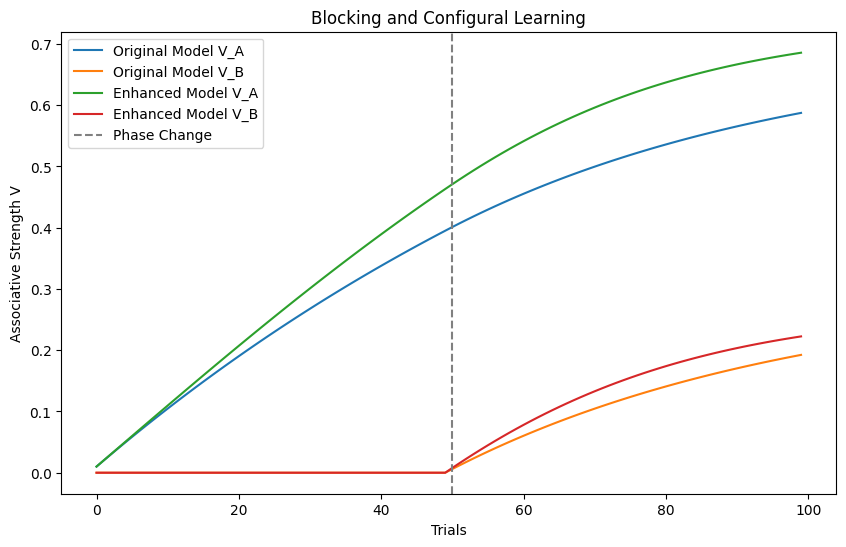

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(V_A_original, label='Original Model V_A')
plt.plot(V_B_original, label='Original Model V_B')
plt.plot(V_A_nonlinear, label='Enhanced Model V_A')
plt.plot(V_B_nonlinear, label='Enhanced Model V_B')
plt.axvline(x=trials, color='grey', linestyle='--', label='Phase Change')
plt.xlabel('Trials')
plt.ylabel('Associative Strength V')
plt.title('Blocking and Configural Learning')
plt.legend()
plt.show()


 The graph illustrates how in the original model, stimulus B does not gain associative strength due to blocking by stimulus A. In the enhanced model with a non-linear function, stimulus B gains strength, demonstrating configural learning.:

# Extinction and Recovery

In [ ]:
alpha = 0.1
beta = 0.1
eta = 0.05
lambda_ = 1.0
trials_acquisition = 50
trials_extinction = 30
trials_recovery = 20

V_active = {'A': 0.0}
V_inactive = {'A': 0.0}

stimuli_acquisition = [['A'] for _ in range(trials_acquisition)]
stimuli_extinction = [['A'] for _ in range(trials_extinction)]
stimuli_recovery = [['A'] for _ in range(trials_recovery)]
stimuli = stimuli_acquisition + stimuli_extinction + stimuli_recovery

phase = ['acquisition'] * trials_acquisition + ['extinction'] * trials_extinction + ['acquisition'] * trials_recovery

V_history = rescorla_wagner_extinction(V_active.copy(), V_inactive.copy(), alpha, beta, eta, lambda_, stimuli, phase)

V_active_values = [V[0]['A'] for V in V_history]
V_inactive_values = [V[1]['A'] for V in V_history]


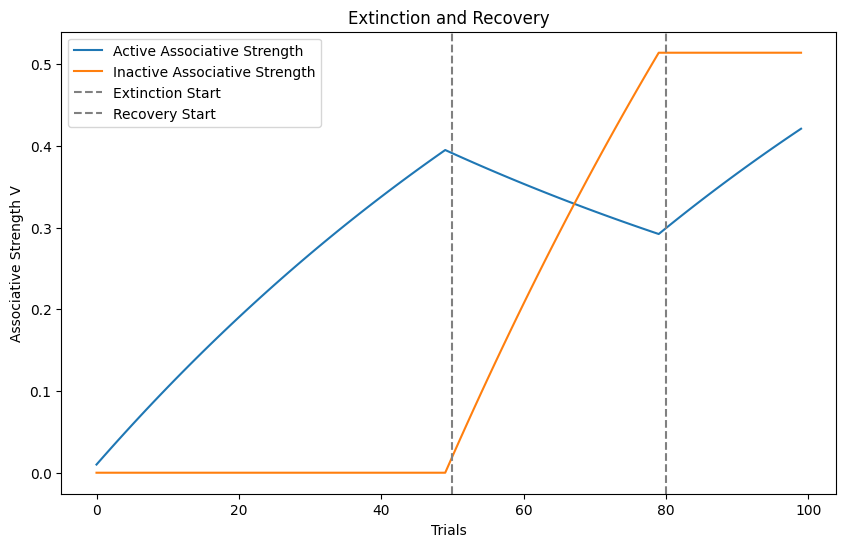

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(V_active_values, label='Active Associative Strength')
plt.plot(V_inactive_values, label='Inactive Associative Strength')
plt.axvline(x=trials_acquisition, color='grey', linestyle='--', label='Extinction Start')
plt.axvline(x=trials_acquisition+trials_extinction, color='grey', linestyle='--', label='Recovery Start')
plt.xlabel('Trials')
plt.ylabel('Associative Strength V')
plt.title('Extinction and Recovery')
plt.legend()
plt.show()


The graph shows that during extinction, the active associative strength decreases, but the inactive strength increases. During recovery, the active strength increases again, demonstrating spontaneous recovery.

# Non-Linear Stimulus Interactions

In [ ]:
alpha = 0.1
beta = 0.1
lambda_ = 1.0
trials = 100

V_original = {'A': 0.0, 'B': 0.0}
V_weighted = {'A': 0.0, 'B': 0.0}

W = {'A': {'A': 1.0, 'B': 0.5}, 'B': {'A': 0.5, 'B': 1.0}}

stimuli = [['A', 'B'] for _ in range(trials)]

V_history_original = rescorla_wagner(V_original.copy(), alpha, beta, lambda_, stimuli)
V_history_weighted = rescorla_wagner_weighted(V_weighted.copy(), alpha, beta, lambda_, stimuli, W)

V_A_original = [V['A'] for V in V_history_original]
V_B_original = [V['B'] for V in V_history_original]
V_A_weighted = [V['A'] for V in V_history_weighted]
V_B_weighted = [V['B'] for V in V_history_weighted]


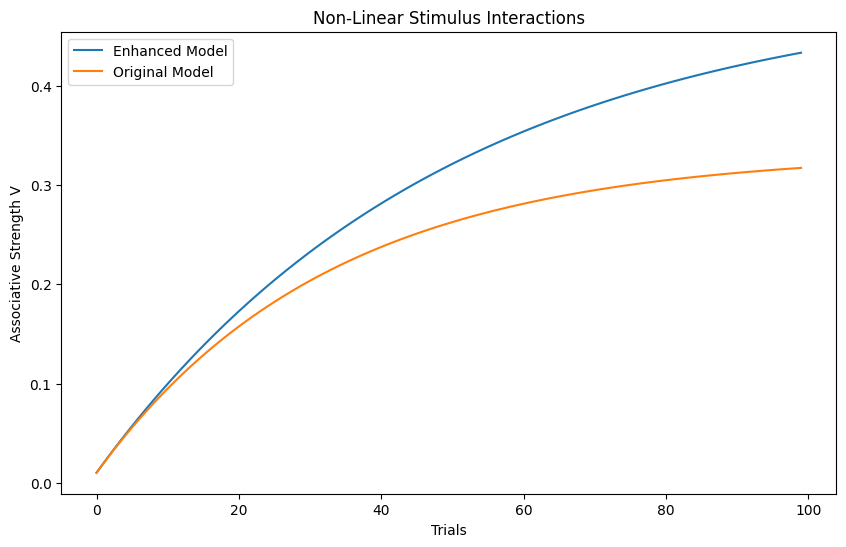

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(V_A_original, label='Enhanced Model')

plt.plot(V_A_weighted, label='Original Model')
plt.xlabel('Trials')
plt.ylabel('Associative Strength V')
plt.title('Non-Linear Stimulus Interactions')
plt.legend()
plt.show()


The graph compares the associative strengths in the original model versus the enhanced model with weighted interactions, showing how the interaction matrix affects learning.

# Combined Enhanced Model

In [ ]:
alpha = 0.1
beta = 0.1
gamma = 0.01
eta = 0.05
lambda_ = 1.0
trials = 100

V_active = {'A': 0.0}
V_inactive = {'A': 0.0}

W = {'A': {'A': 1.0}}

def f(V_tot):
    return np.tanh(V_tot)  # Example non-linear function

stimuli = [['A'] for _ in range(trials)]
phase = ['acquisition' if trial < 70 else 'extinction' for trial in range(trials)]

V_history_enhanced = rescorla_wagner_enhanced(V_active.copy(), V_inactive.copy(), alpha, beta, gamma, eta, lambda_, stimuli, W, f, phase)

V_active_values = [V[0]['A'] for V in V_history_enhanced]
V_inactive_values = [V[1]['A'] for V in V_history_enhanced]


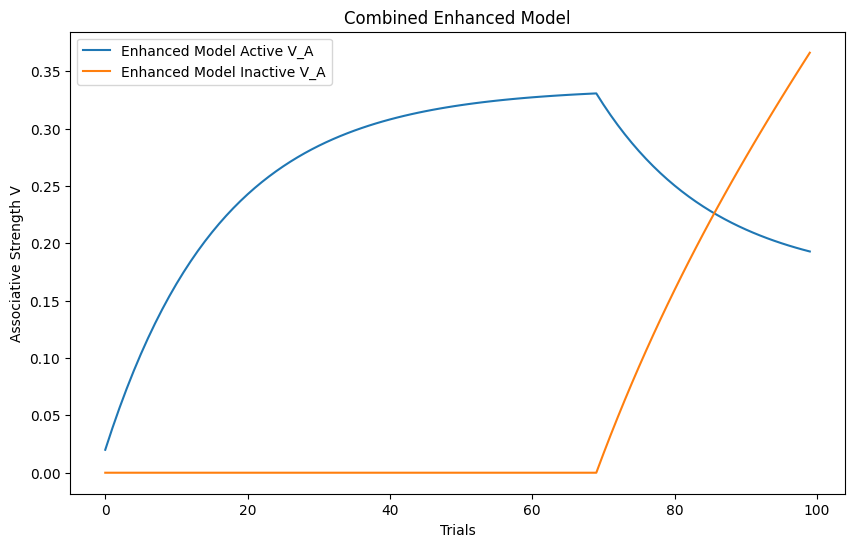

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(V_active_values, label='Enhanced Model Active V_A')
plt.plot(V_inactive_values, label='Enhanced Model Inactive V_A')
plt.xlabel('Trials')
plt.ylabel('Associative Strength V')
plt.title('Combined Enhanced Model')
plt.legend()
plt.show()
